<a href="https://colab.research.google.com/github/BiniyamAFirde/ICU-Beds-Analysis/blob/main/ICU_BEDS_IN_USA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd

In [4]:
df=pd.read_csv('/content/hospital_beds_USA_v1.csv')

In [5]:
df.shape

(5713, 12)

In [6]:
df.head()

,country,state,county,lat,lng,type,measure,beds,population,year,source,source_url
0,US,AK,aleutians east,63.588753,-154.493062,ICU,1000HAB,0.000000,3338,2019,khn,https://khn.org/news/as-coronavirus-spreads-wi...
1,US,AK,aleutians west,63.588753,-154.493062,ICU,1000HAB,0.000000,5784,2019,khn,https://khn.org/news/as-coronavirus-spreads-wi...
2,US,AK,anchorage,63.588753,-154.493062,ACUTE,1000HAB,2.182916,298225,2018,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...
3,US,AK,anchorage,63.588753,-154.493062,ICU,1000HAB,0.244782,298225,2019,khn,https://khn.org/news/as-coronavirus-spreads-wi...
4,US,AK,anchorage,63.588753,-154.493062,OTHER,1000HAB,0.191131,298225,2019,arcgis,https://services1.arcgis.com/Hp6G80Pky0om7QvQ/...


Checking if there is a missing value

In [9]:
df.isnull().sum().sum()  # Total missing values across all columns


0

In [11]:
# Step 1: Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
#  Data Cleaning
# Drop "country" column (all US)
df = df.drop(columns=['country'])

In [13]:
# Rename columns for consistency (lowercase)
df.columns = [col.lower() for col in df.columns]

In [14]:
# Filter only ICU beds data
df = df[df['type'] == 'ICU']

In [15]:
# Handle missing beds data (replace NaN with 0)
df['beds'] = df['beds'].fillna(0)

In [16]:
# Convert beds per 1000 inhabitants to absolute ICU beds
df['absolute_beds'] = (df['beds'] * df['population']) / 1000

In [17]:
# Step 4: Feature Engineering
# ICU Beds per Capita
df['icu_beds_per_capita'] = df['absolute_beds'] / df['population']

# Population density weight (optional if you have area data - if not, assume all weight=1)
df['population_density_weight'] = 1  # Adjust if you have actual density data per county

# Ventilator Demand Index (VDI)
df['vdi'] = (1 / df['icu_beds_per_capita']) * df['population_density_weight']

# Shortage Risk Flag
def classify_risk(row):
    beds_per_person = row['icu_beds_per_capita']
    if beds_per_person > 1/2000:
        return 'Low Risk'
    elif beds_per_person > 1/5000:
        return 'Moderate Risk'
    else:
        return 'High Risk'

df['shortage_risk'] = df.apply(classify_risk, axis=1)

Top 10 High Risk Counties:
     state          county  vdi  absolute_beds  population
0       AK  aleutians east  inf            0.0        3338
3338    NE            loup  inf            0.0         537
3404    NH        sullivan  inf            0.0       43073
3379    NE         wheeler  inf            0.0         846
3372    NE          thomas  inf            0.0         643
3370    NE         stanton  inf            0.0        6020
3369    NE           sioux  inf            0.0        1256
3368    NE         sherman  inf            0.0        3048
3342    NE       mcpherson  inf            0.0         432
3337    NE           logan  inf            0.0         919


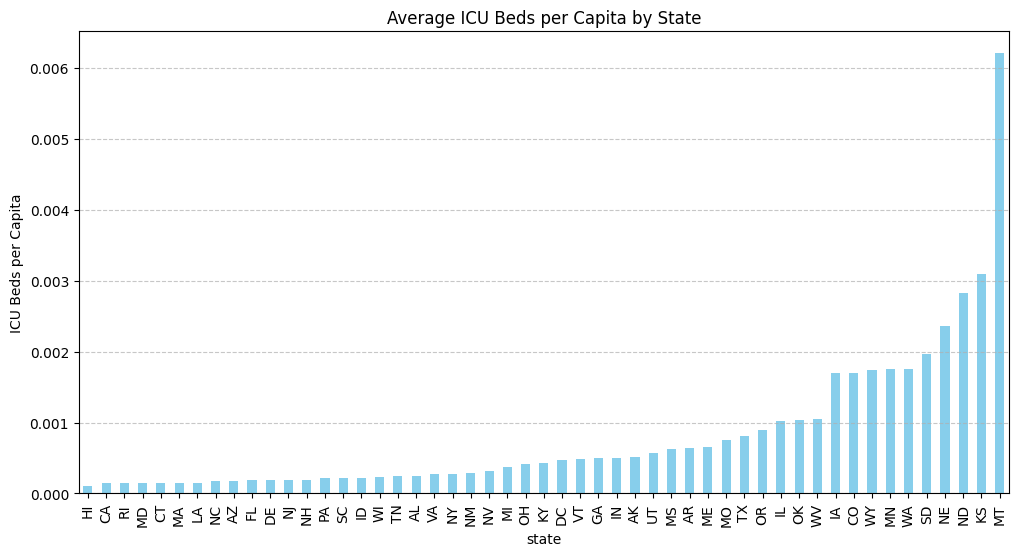

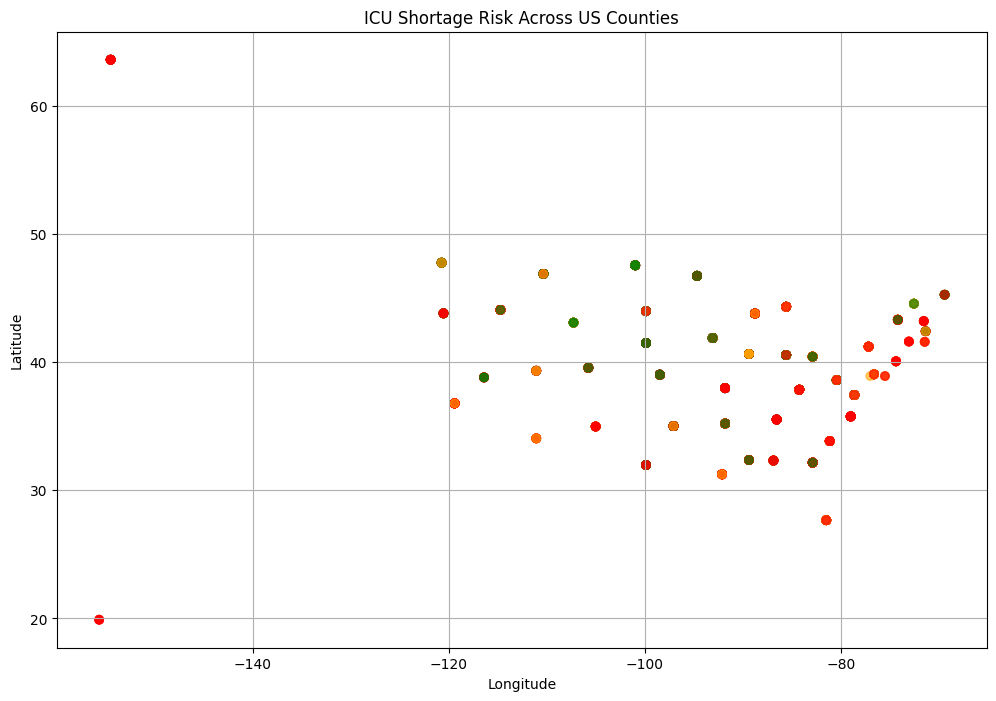

In [18]:
# Step 5: Exploratory Data Analysis (EDA)
# Top 10 Counties with Highest ICU Shortage Risk (High Risk)
high_risk = df[df['shortage_risk'] == 'High Risk']
top_10_high_risk = high_risk.sort_values('vdi', ascending=False).head(10)

print("Top 10 High Risk Counties:")
print(top_10_high_risk[['state', 'county', 'vdi', 'absolute_beds', 'population']])

# ICU Beds per Capita by State (bar plot)
state_avg_beds = df.groupby('state')['icu_beds_per_capita'].mean().sort_values()

plt.figure(figsize=(12, 6))
state_avg_beds.plot(kind='bar', color='skyblue')
plt.title('Average ICU Beds per Capita by State')
plt.ylabel('ICU Beds per Capita')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Map Visualization (Scatterplot with color = risk level)
plt.figure(figsize=(12, 8))
colors = {'Low Risk':'green', 'Moderate Risk':'orange', 'High Risk':'red'}

plt.scatter(df['lng'], df['lat'], c=df['shortage_risk'].map(colors), alpha=0.6)
plt.title('ICU Shortage Risk Across US Counties')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [19]:
# Optional: Save Cleaned Data for Tableau
df.to_csv('cleaned_icu_beds_data.csv', index=False)

# Summary Stats for README
print("\nSummary Statistics for ICU Beds per Capita:")
print(df['icu_beds_per_capita'].describe())

print("\nCount of Counties by Risk Level:")
print(df['shortage_risk'].value_counts())


Summary Statistics for ICU Beds per Capita:
count    3142.000000
mean        0.000921
std         0.002253
min         0.000000
25%         0.000000
50%         0.000197
75%         0.000707
max         0.030201
Name: icu_beds_per_capita, dtype: float64

Count of Counties by Risk Level:
shortage_risk
High Risk        1585
Low Risk          904
Moderate Risk     653
Name: count, dtype: int64
